In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

In [2]:
# Load video using OpenCV
video_path = 'clouds.mp4'
cap = cv2.VideoCapture(video_path)

ret, frame = cap.read()
frame_width = 44
frame_height = 60

# Check if the video opened successfully
if not cap.isOpened():
    raise Exception("Error opening the video. Please check the file path and codec.")

# Define a torchvision transform for resizing
resize_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((frame_width, frame_height)),
    transforms.ToTensor(),
])

In [3]:
# Initialize a list to store video frames
frames = []

# Read frames from the video
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert BGR image to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Apply resizing transform
    resized_frame = resize_transform(frame_rgb)

    # Append the frame to the list
    frames.append(resized_frame)

# Convert the list of frames to a PyTorch tensor
video_tensor = torch.stack(frames)

# Print tensor shape
print("Video Tensor Shape:", video_tensor.shape)

# Release the video capture object
cap.release()

Video Tensor Shape: torch.Size([329, 3, 44, 60])


In [4]:
class CloudDataset(Dataset):
    def __init__(self, image_sequence):
        self.ims = image_sequence
        self.ks = 5

    def __len__(self):
        return (self.ims.shape[0] - 1)

    def __getitem__(self, idx):
        return self.ims[idx], self.ims[idx + 1]
    
ds = CloudDataset(video_tensor)
data_loader = DataLoader(ds, batch_size=64, shuffle=True)

/opt/homebrew/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


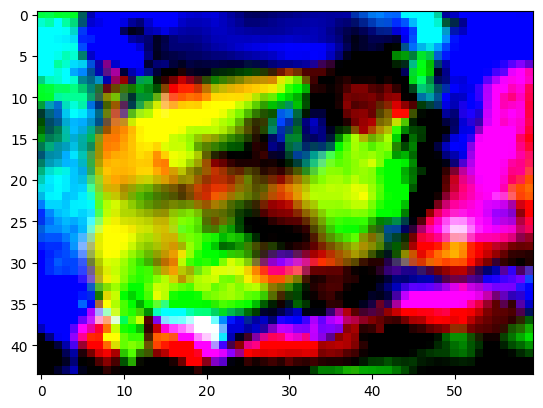

In [5]:
up2 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)

class Conv(nn.Module):
    def __init__(self, ks1=5, ks2=5):
        super().__init__()
        self.conv = nn.Conv2d(3, 3, kernel_size=ks1, padding=ks1//2, bias=False)
        self.conv2 = nn.Conv2d(3, 3, kernel_size=ks2, padding=ks2//2, bias=False)
        self.bn = nn.BatchNorm2d(3)

        # iniitalse kernels to have no effect
        # self.conv.weight.data.fill_(0)
        # self.conv2.weight.data.fill_(0)
        # self.conv2.weight.data[0, 0, 2, 2] = 1
        # self.conv2.weight.data[1, 1, 2, 2] = 1
        # self.conv2.weight.data[2, 2, 2, 2] = 1

    def forward(self, x):
        xdim = x.dim()
        if xdim == 3:
            x = x.unsqueeze(0)

        xd2 = transforms.Compose([transforms.Resize((frame_width // 4, frame_height // 4))])(x)
        xd2_up = up2(xd2)
        x2 = x - xd2_up
        xd2_n = self.conv2(xd2)
        x2_n = self.conv(x2)
        x_out = x2_n + up2(xd2_n)
        x_out = self.bn(x_out)

        if xdim == 3:
            x_out = x_out.squeeze(0)
        return x_out
    
model = Conv()

plt.imshow(model(ds[0][0]).permute(1, 2, 0).detach().numpy())

In [28]:
model = Conv(ks1=5, ks2=5)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0025, weight_decay=5e-4)

In [29]:
num_epochs = 300

for epoch in range(num_epochs):
    total_loss = 0.0

    for batch in data_loader:
        input_data = batch[0]
        targets = batch[1]
        
        optimizer.zero_grad()

        outputs = model(input_data)

        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(data_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.5f}')

Epoch 1/300, Loss: 1.07328
Epoch 2/300, Loss: 0.88882
Epoch 3/300, Loss: 0.82794
Epoch 4/300, Loss: 0.78625
Epoch 5/300, Loss: 0.74509
Epoch 6/300, Loss: 0.70615
Epoch 7/300, Loss: 0.66937
Epoch 8/300, Loss: 0.63569
Epoch 9/300, Loss: 0.60477
Epoch 10/300, Loss: 0.57174
Epoch 11/300, Loss: 0.54376
Epoch 12/300, Loss: 0.51603
Epoch 13/300, Loss: 0.48911
Epoch 14/300, Loss: 0.46623
Epoch 15/300, Loss: 0.44249
Epoch 16/300, Loss: 0.41930
Epoch 17/300, Loss: 0.39746
Epoch 18/300, Loss: 0.37670
Epoch 19/300, Loss: 0.35765
Epoch 20/300, Loss: 0.33946
Epoch 21/300, Loss: 0.31975
Epoch 22/300, Loss: 0.30406
Epoch 23/300, Loss: 0.28812
Epoch 24/300, Loss: 0.27265
Epoch 25/300, Loss: 0.25813
Epoch 26/300, Loss: 0.24492
Epoch 27/300, Loss: 0.23060
Epoch 28/300, Loss: 0.21779
Epoch 29/300, Loss: 0.20542
Epoch 30/300, Loss: 0.19454
Epoch 31/300, Loss: 0.18338
Epoch 32/300, Loss: 0.17363
Epoch 33/300, Loss: 0.16330
Epoch 34/300, Loss: 0.15423
Epoch 35/300, Loss: 0.14540
Epoch 36/300, Loss: 0.13736
E

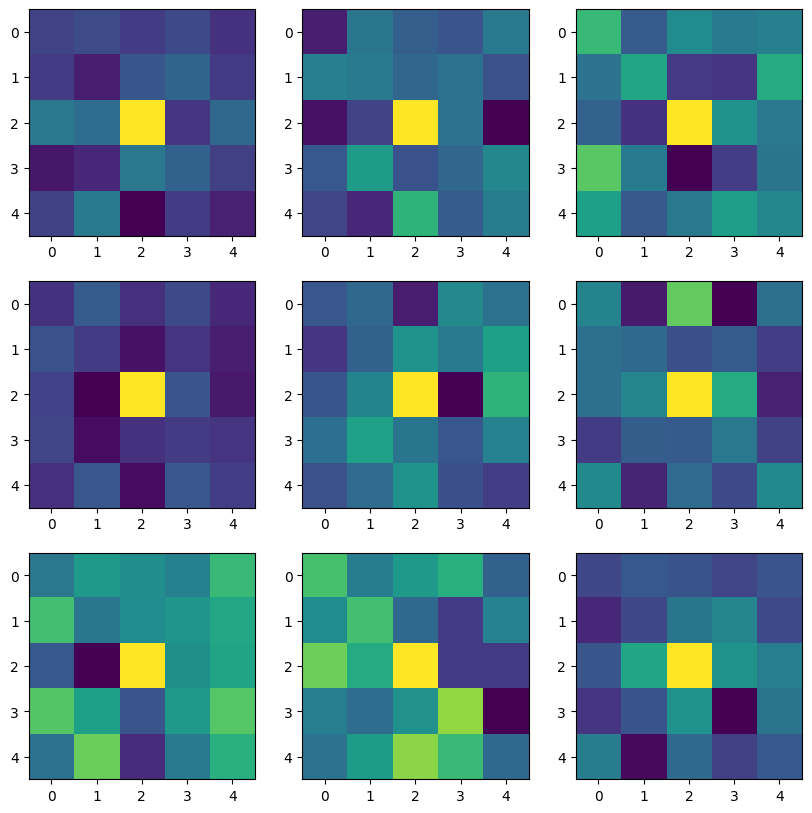

In [30]:
# plot heatmaps of all 9 kernels
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        axs[i, j].imshow(model.conv2.weight[i, j].data.numpy())

/opt/homebrew/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB dat

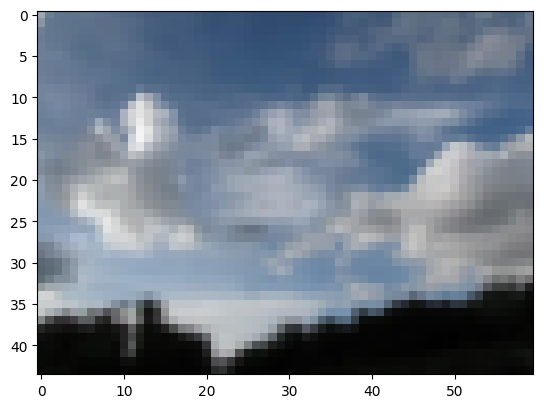

In [27]:
next_frame = ds[-1][0]

def update(frame):
    global next_frame
    if frame < 50:
        plt.imshow(ds[-(50-frame+1)][0].permute(1, 2, 0))
    else:
        next_frame = model(next_frame)
        plt.imshow(next_frame.detach().permute(1, 2, 0))

animation = FuncAnimation(plt.gcf(), update, frames=50, repeat=True, interval=50)

# save animarion as mp4 video file
animation.save('hierarchy.mp4', writer='ffmpeg', fps=10, dpi=200)

from IPython.display import HTML
HTML(animation.to_jshtml())